In [18]:
## This is final check file to make sure math is working correctly and is similar to originally tested models from team in python
#from ShelterData_ML_Final.ipynb

In [61]:
### Update your code here to test different csvs
import shutil; shutil.copyfile('final_pipeline_prediction_sample_Test.csv', 'final_pipeline_prediction.csv')



'final_pipeline_prediction.csv'

/tmp/ipykernel_204/2830468950.py:9: DtypeWarning: Columns (2,3,6,7,9,10,11,12,13,15,19,20,21,23,26,28,31,32,33,35,39,43,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df_truth = pd.read_csv('df_cat_dog_harmonized.csv')
/tmp/ipykernel_204/2830468950.py:10: DtypeWarning: Columns (27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pred = pd.read_csv('final_pipeline_prediction.csv')


Confusion Matrix:
[[5105 1106]
 [ 387 1962]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      6211
           1       0.64      0.84      0.72      2349

    accuracy                           0.83      8560
   macro avg       0.78      0.83      0.80      8560
weighted avg       0.85      0.83      0.83      8560

Accuracy: 0.8256
Precision: 0.6395
Recall: 0.8352
F1 Score: 0.7244
AUC: 0.8856


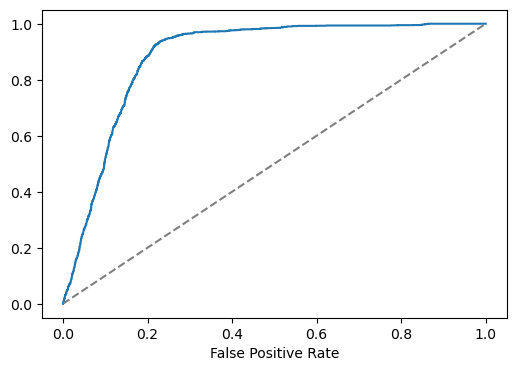

In [62]:
#Checking Prediciton first
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, classification_report
)
import matplotlib.pyplot as plt
#load
df_truth = pd.read_csv('df_cat_dog_harmonized.csv')
df_pred = pd.read_csv('final_pipeline_prediction.csv')

#Merge
df = pd.merge(df_truth[['primary_key', 'outcome_type_harmonized_grouped']], 
              df_pred[['primary_key', 'predicted_label', 'predicted_proba']], 
              on='primary_key')

#Binarize ground truth: adopted = 1, else 0

df['actual'] = df['outcome_type_harmonized_grouped'].apply(lambda x: 1 if str(x).strip().lower() == 'adopted' else 0)
df['predicted'] = df['predicted_label']


# Metrics

print("Confusion Matrix:")
print(confusion_matrix(df['actual'], df['predicted']))

print("\nClassification Report:")
print(classification_report(df['actual'], df['predicted']))

print(f"Accuracy: {accuracy_score(df['actual'], df['predicted']):.4f}")
print(f"Precision: {precision_score(df['actual'], df['predicted']):.4f}")
print(f"Recall: {recall_score(df['actual'], df['predicted']):.4f}")
print(f"F1 Score: {f1_score(df['actual'], df['predicted']):.4f}")


# AUC

if 'predicted_proba' in df.columns:
    auc = roc_auc_score(df['actual'], df['predicted_proba'])
    print(f"AUC: {auc:.4f}")

#Plot ROC Curve
    fpr, tpr, _ = roc_curve(df['actual'], df['predicted_proba'])
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")


In [63]:
#Checking predicted stay lenght but only for adopted 
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load CSVs
df_truth = pd.read_csv('df_cat_dog_harmonized.csv')
df_pred = pd.read_csv('final_pipeline_prediction.csv')

# Merge on primary_key
df = pd.merge(
    df_truth[['primary_key', 'stay_length_days']],
    df_pred[['primary_key', 'stay_length_predicted', 'predicted_proba']],
    on='primary_key'
)

#  only include rows where predicted_proba >= 0.5
df_filtered = df[df['predicted_proba'] >= 0.5].copy()

# Drop rows with missing values in either column
df_filtered = df_filtered.dropna(subset=['stay_length_days', 'stay_length_predicted'])

# Evaluate metrics
r2 = r2_score(df_filtered['stay_length_days'], df_filtered['stay_length_predicted'])
mse = mean_squared_error(df_filtered['stay_length_days'], df_filtered['stay_length_predicted'])
mae = mean_absolute_error(df_filtered['stay_length_days'], df_filtered['stay_length_predicted'])

print(f"Filtered Rows: {len(df_filtered)}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")


/tmp/ipykernel_204/3082087306.py:6: DtypeWarning: Columns (2,3,6,7,9,10,11,12,13,15,19,20,21,23,26,28,31,32,33,35,39,43,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df_truth = pd.read_csv('df_cat_dog_harmonized.csv')


Filtered Rows: 2966
R² Score: -0.0021
Mean Absolute Error (MAE): 10.59
Mean Squared Error (MSE): 315.72


/tmp/ipykernel_204/3082087306.py:7: DtypeWarning: Columns (27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pred = pd.read_csv('final_pipeline_prediction.csv')


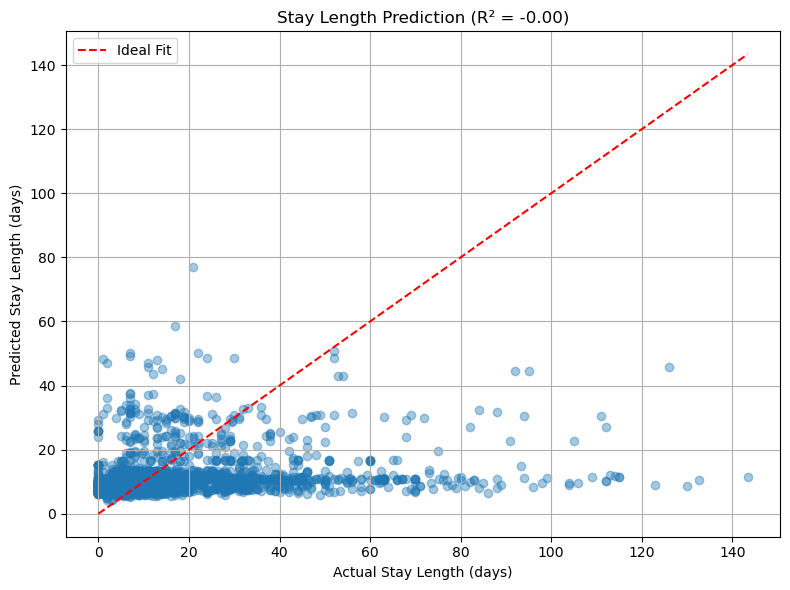

In [64]:
#R2 is pretty similar to what we expected
# Plot: actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['stay_length_days'], df_filtered['stay_length_predicted'], alpha=0.4)
plt.plot([df_filtered['stay_length_days'].min(), df_filtered['stay_length_days'].max()],
         [df_filtered['stay_length_days'].min(), df_filtered['stay_length_days'].max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Stay Length (days)')
plt.ylabel('Predicted Stay Length (days)')
plt.title(f'Stay Length Prediction (R² = {r2:.2f})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
#Lastly, we'll predict multiclass outcome

import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load
df_truth = pd.read_csv('df_cat_dog_harmonized.csv')
df_pred = pd.read_csv('final_pipeline_prediction.csv')

# Merge on primary_key
df = pd.merge(
    df_truth[['primary_key', 'outcome_type_harmonized']],
    df_pred[['primary_key', 'proba_foster', 'proba_rescue', 'proba_rto', 'non_adopted_label']],
    on='primary_key'
)

# Clean and map ground truth to integer labels #EDIT, do we need to map all? I don't think so as we drop predict prob<0.5
label_map = {
    "foster": 0,
    "foster to adopt": 0,
    "rtf": 0,
    "rescue": 1,
    "return to rescue": 1,
    "return to owner": 2
}
df['outcome_type_harmonized'] = df['outcome_type_harmonized'].str.lower().str.strip()
df['actual_label'] = df['outcome_type_harmonized'].map(label_map)
df['predicted_label'] = df['non_adopted_label'].astype(int)

# # Drop rows with unknown classes 
# df = df.dropna(subset=['actual_label'])

# Get predicted probability for the predicted label
proba_cols = ['proba_foster', 'proba_rescue', 'proba_rto']
df['predicted_proba'] = df.apply(lambda row: row[proba_cols[row['predicted_label']]], axis=1)

# Keep only rows where predicted class confidence is low
df = df[df['predicted_proba'] < 0.5]



# Evaluation
print("Unique ground truth labels:")
print(df['outcome_type_harmonized'].unique())

print("\nValue counts after mapping:")
print(df['actual_label'].value_counts(dropna=False))

#Drop again after filtering — some rows may still have NaN actual_label
df = df.dropna(subset=['actual_label'])


print("\nConfusion Matrix:")
print(confusion_matrix(df['actual_label'], df['predicted_label']))

print("\nClassification Report:")
print(classification_report(df['actual_label'], df['predicted_label'],
                            target_names=['foster', 'rescue', 'return_to_owner']))




/tmp/ipykernel_204/241022477.py:9: DtypeWarning: Columns (2,3,6,7,9,10,11,12,13,15,19,20,21,23,26,28,31,32,33,35,39,43,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df_truth = pd.read_csv('df_cat_dog_harmonized.csv')


Unique ground truth labels:
['return to owner' 'retailer' 'adoption' 'unknown' 'foster' 'transfer'
 'euthanasia' 'rtf' 'disposal' 'rescue' 'found anim' 'died'
 'neutered/spayed' 'released to wild' 'duplicate']

Value counts after mapping:
actual_label
0.0    653
NaN    438
2.0     51
1.0     40
Name: count, dtype: int64

Confusion Matrix:
[[610  35   8]
 [ 11  16  13]
 [ 20  17  14]]

Classification Report:
                 precision    recall  f1-score   support

         foster       0.95      0.93      0.94       653
         rescue       0.24      0.40      0.30        40
return_to_owner       0.40      0.27      0.33        51

       accuracy                           0.86       744
      macro avg       0.53      0.54      0.52       744
   weighted avg       0.88      0.86      0.87       744



/tmp/ipykernel_204/241022477.py:10: DtypeWarning: Columns (27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pred = pd.read_csv('final_pipeline_prediction.csv')


In [71]:
df

,primary_key,outcome_type_harmonized,proba_foster,proba_rescue,proba_rto,non_adopted_label,actual_label,predicted_label,predicted_proba
3,59638_45811,return to owner,0.194913,0.498925,0.306162,1,2.0,1,0.498925
81,77242_45720,return to owner,0.457632,0.264304,0.278064,0,2.0,0,0.457632
98,77967_45663,foster,0.498697,0.412704,0.088599,0,0.0,0,0.498697
116,78914_45769,foster,0.294022,0.360546,0.345432,1,0.0,1,0.360546
182,81044_45668,foster,0.246375,0.423432,0.330193,1,0.0,1,0.423432
...,...,...,...,...,...,...,...,...,...
8434,A740263_45780,rescue,0.183798,0.402767,0.413435,2,1.0,2,0.413435
8435,A740264_45780,rescue,0.181640,0.403832,0.414528,2,1.0,2,0.414528
8489,A740675_45790,rescue,0.149257,0.398197,0.452545,2,1.0,2,0.452545
8490,A740676_45790,rescue,0.149257,0.398197,0.452545,2,1.0,2,0.452545


Duplicate primary keys: 1

 NaN counts in probability columns:
proba_foster    0
proba_rescue    0
proba_rto       0
dtype: int64


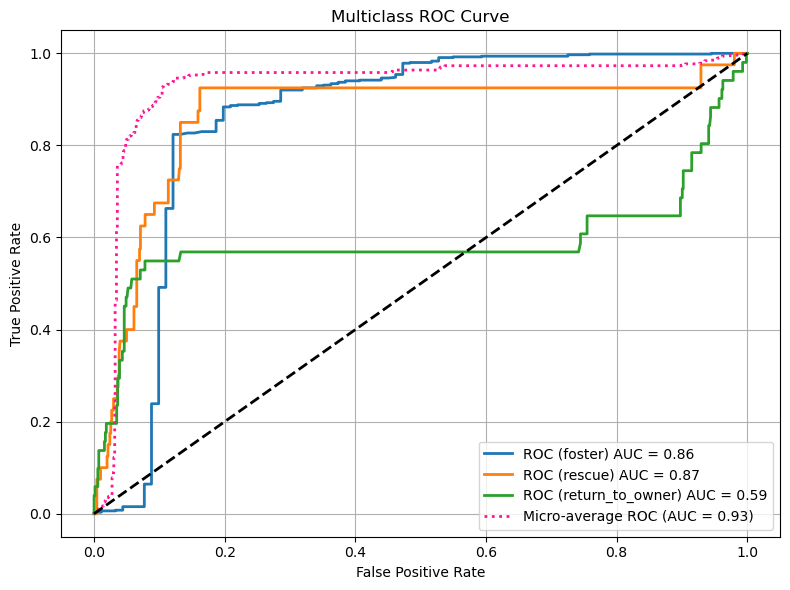

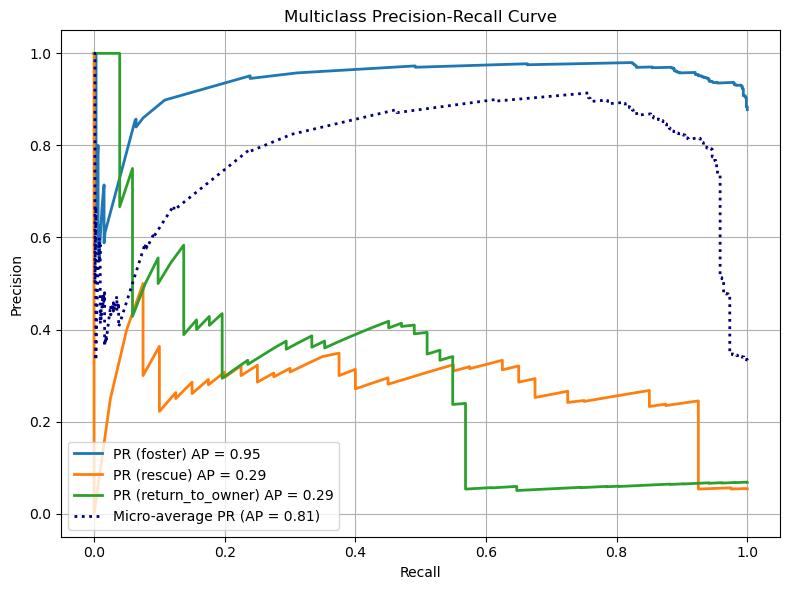


 Counts per class in actual_label:
actual_label
0    653
1     40
2     51
Name: count, dtype: int64


In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


# Filter out rows where any required column is missing
required_cols = ['actual_label', 'proba_foster', 'proba_rescue', 'proba_rto']
df_filtered = df.dropna(subset=required_cols).copy()

# Cast label to int
df_filtered['actual_label'] = df_filtered['actual_label'].astype(int)

# Check for duplicate primary keys
num_duplicates = df_filtered.duplicated(subset=['primary_key']).sum()
print(f"Duplicate primary keys: {num_duplicates}")

# Show NaNs in proba columns (should be 0 now)
print("\n NaN counts in probability columns:")
print(df_filtered[['proba_foster', 'proba_rescue', 'proba_rto']].isna().sum())

# Ground truth binarized
y_test_bin = label_binarize(df_filtered['actual_label'], classes=[0, 1, 2])

# Score array
y_score = df_filtered[['proba_foster', 'proba_rescue', 'proba_rto']].values

fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure(figsize=(8, 6))
class_names = ['foster', 'rescue', 'return_to_owner']
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC ({class_names[i]}) AUC = {roc_auc[i]:.2f}')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=2,
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


precision, recall, avg_precision = {}, {}, {}
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# Micro-average PRC
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
avg_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")

# Plot PRC
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR ({class_names[i]}) AP = {avg_precision[i]:.2f}')

plt.plot(recall["micro"], precision["micro"], color='navy', linestyle=':', linewidth=2,
         label=f'Micro-average PR (AP = {avg_precision["micro"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n Counts per class in actual_label:")
print(df_filtered['actual_label'].value_counts().sort_index())








In [68]:
df_filtered

,primary_key,outcome_type_harmonized,proba_foster,proba_rescue,proba_rto,non_adopted_label,actual_label,predicted_label,predicted_proba
0,56266_45782,return to owner,0.149977,0.032622,0.817401,2,2,2,0.817401
1,56266_45790,return to owner,0.151031,0.025823,0.823146,2,2,2,0.823146
2,56266_45811,return to owner,0.151031,0.025823,0.823146,2,2,2,0.823146
3,59638_45811,return to owner,0.194913,0.498925,0.306162,1,2,1,0.498925
4,61750_45796,foster,0.331421,0.049840,0.618739,2,0,2,0.618739
...,...,...,...,...,...,...,...,...,...
8544,A741484_45805,rescue,0.018767,0.965910,0.015323,1,1,1,0.965910
8550,A741718_45809,rescue,0.264202,0.580350,0.155448,1,1,1,0.580350
8551,A741720_45809,rescue,0.264202,0.580350,0.155448,1,1,1,0.580350
8556,A742577_45819,return to owner,0.017896,0.052850,0.929253,2,2,2,0.929253


In [40]:
# Count the occurrences of each outcome_type_harmonized
outcome_counts = df['outcome_type_harmonized'].value_counts().reset_index()
outcome_counts.columns = ['Outcome Type', 'Count']

print(outcome_counts)


      Outcome Type  Count
0              rtf   1533
1           rescue    811
2  return to owner    747
3           foster    502


In [41]:
print(df_filtered['proba_rto'].describe())


count    3593.000000
mean        0.251318
std         0.285337
min         0.010085
25%         0.026147
50%         0.127453
75%         0.289792
max         0.948015
Name: proba_rto, dtype: float64


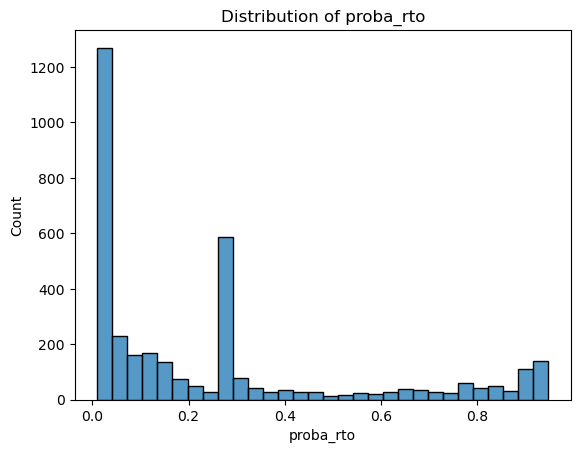

In [42]:
import seaborn as sns
sns.histplot(df_filtered['proba_rto'], bins=30)
plt.title('Distribution of proba_rto')
plt.show()
